# Processing for the Science Scribbler initial data

This python script is to take the output from the science scribbler zooniverse project, and to extract the relevent information from it.

The problem is that we have a volume of data, that is like a stack of images, and we 

In [1]:
# import the tools that are needed for the script
import pandas as pd
import numpy as np
import h5py
import json

/home/mark/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load in the relevent datasets, they are downloaded from the zooniverse project design page
# these files are csv files, or comma seperated variables.  they load easily in excell,
# but i need to do some more complicated analysis so i will use the python tool Pandas
classifications = pd.read_csv('../data/science-scribbler-classifications.csv')
subjects = pd.read_csv('../data/science-scribbler-subjects.csv')
data = h5py.File('../data/data.h5', 'r')

In [3]:
# Some of the columbs in the files are complex data rather than a number.
# This is stored in a format called json which needs to be read by the script to make it easier to use
classifications['anno'] = classifications['annotations'].apply(json.loads)
classifications['subj'] = classifications['subject_data'].apply(json.loads)
subjects['subject_metadata'] = subjects['metadata'].apply(json.loads)

In [4]:
# Find out which subject (picture) the classification (work the user did) was on
classifications['subject_id'] = classifications['subj'].apply(lambda x: int(x.keys()[0]))

In [5]:
# Now get the relevent information from the subject about where it is in the volume
subjects['subject_metadata_xstart'] = subjects['subject_metadata'].apply(lambda x: int(x['xstart']))
subjects['subject_metadata_ystart'] = subjects['subject_metadata'].apply(lambda x: int(x['ystart']))
subjects['subject_metadata_slice'] = subjects['subject_metadata'].apply(lambda x: int(x['slice']))

In [6]:
# Now we need to extract the task information from the file
# this is where we get information like where the citezen scientists drew on the pictures.
for task in ['T0', 'T1', 'T2', 'T3']:
    classifications[task] = classifications['anno'].apply(
        lambda x: list(item for item in x if item["task"] == task))

In [7]:
# get all the information about the subjects and classifications and put it in one big table
merged = pd.merge(classifications, subjects, on='subject_id')

In [8]:
len(merged['T3'])

14288

In [9]:
a = pd.DataFrame(
    pd.DataFrame.from_records(
        merged.T3.apply(
            lambda x: x[0]['value'] if len(x) > 0 else []
        ).tolist()
    ).stack().reset_index(level=1, drop=True).rename('T3'))

In [10]:
df3 = pd.merge(a, merged, left_index=True, right_index=True)

In [11]:
df3 = df3.reset_index(drop=True)

In [12]:
df3['T3_x'][0]

{u'angle': -17.102728969052365,
 u'details': [],
 u'frame': 0,
 u'rx': 1.7767646246904572,
 u'ry': 1.8373690553868847,
 u'tool': 0,
 u'tool_label': u'Object Outliner',
 u'x': 264.5253601074219,
 u'y': 174.06675720214844}

In [42]:
# Extract the center position of the object outline for now
df3['T3_x_posx'] = df3['T3_x'].apply(lambda x: float(x['x']))
df3['T3_x_posy'] = df3['T3_x'].apply(lambda x: float(x['y']))

df3['T3_x_true_posx'] = df3['T3_x_posx'] + df3['subject_metadata_xstart']
df3['T3_x_true_posy'] = df3['T3_x_posy'] + df3['subject_metadata_ystart']

In [43]:
# Take a quick look at what slices we have data for
df3['subject_metadata_slice'].unique()

array([141, 261, 240, 189, 303, 108, 294,  93, 207, 177,  78, 210,  60,
       102, 111,  15,  18,  45,  21, 216,  99,   3, 252, 234,  75,  63,
        54,  30,  51,  24,  39,  87,  27, 120,  36, 132,  72,  12, 231,
        96,   0,  33, 162,   9, 135,   6, 147,  57, 105, 165, 117, 156,
        42, 138, 144,  84, 183, 219, 150, 186,  81, 258, 273, 129, 153,
       114, 126,  90,  48, 222, 255, 192, 123, 297, 168,  69, 180, 291,
       225, 228, 246, 285, 270, 171, 159,  66, 267, 195, 237, 264, 201,
       276, 174, 198, 249, 288])

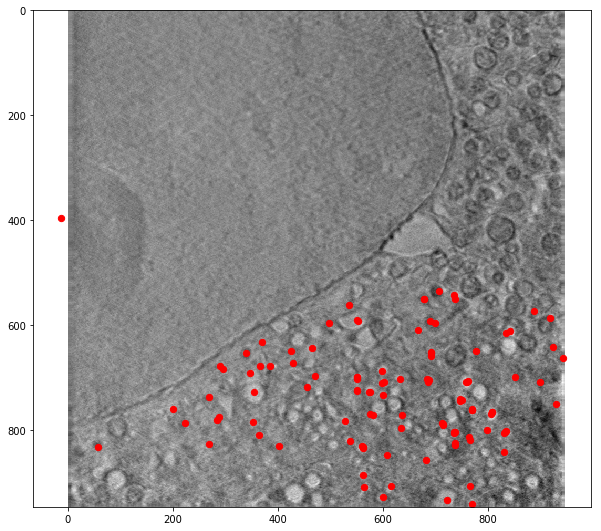

In [54]:
#Pick a slice for testing, and plot a red dot wherever the selected centre is

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(data['data'][45,:,:],cmap='gray')

df = df3.loc[df3['subject_metadata_slice'] == 135]

plt.scatter(x=df['T3_x_true_posx'].values, y=df['T3_x_true_posy'].values, c='r', s=40)

plt.show()

In [29]:
merged['metadata_y'][0]

'{"id":"127","xend":"946","yend":"946","slice":"21","prefix":"cryoSXT-medium","xstart":"646","ystart":"646","#source":"/dls/tmp/ForImanol/survos_workshop_s15t.rec","filename":"cryoSXT-medium_21_646x946x646x946.png","#transpose":"1,0,2"}'